***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32-D>16-D>8-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = c:\Users\knoor\Downloads\temp\HD-CapsNet\Training_and_Analysis\1_FMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('2_FMNIST/HD_CapsNet/HD-CapsNet')

# Import Dataset : FMNIST

In [6]:
dataset = datasets.F_MNIST(version = 'ALL') # importing Fashion MNIST Dataset
# dataset = datasets.F_MNIST(version = 'reduce') # importing Fashion MNIST Dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples


## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [11]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = dataset['x_train'].shape[1:], 
                                      input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                      input_shape_ym  = dataset['y_train_medium'].shape[1:],
                                      input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                      no_coarse_class = number_of_classes_c, 
                                      no_medium_class = number_of_classes_m, 
                                      no_fine_class   = number_of_classes_f,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = number_of_classes_m, 
                              number_of_classes_f = number_of_classes_f, 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1
                       )
    
    model.save_weights(model_save_dir)

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 12s 16ms/step - loss: 0.0154 - prediction_coarse_loss: 6.6669e-04 - prediction_medium_loss: 0.0178 - prediction_fine_loss: 0.0413 - prediction_coarse_accuracy: 0.9992 - prediction_medium_accuracy: 0.9779 - prediction_fine_accuracy: 0.9483
1. loss ==> 0.015412844717502594
2. prediction_coarse_loss ==> 0.000666687439661473
3. prediction_medium_loss ==> 0.01780182309448719
4. prediction_fine_loss ==> 0.04132170230150223
5. prediction_coarse_accuracy ==> 0.9991999864578247
6. prediction_medium_accuracy ==> 0.9779000282287598
7. prediction_fine_accuracy ==> 0.9483000040054321
313/313 [==============================] - 3s 8ms/step


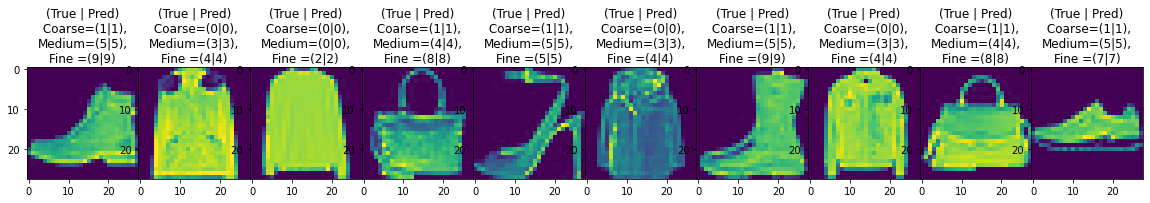

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix Level = 0 


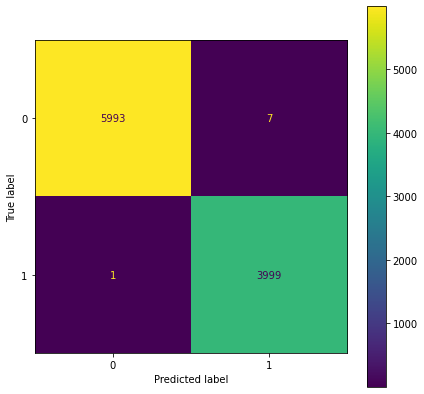


  • Classification Report for Level = 0 

              precision    recall  f1-score   support

           0    0.99983   0.99883   0.99933      6000
           1    0.99825   0.99975   0.99900      4000

    accuracy                        0.99920     10000
   macro avg    0.99904   0.99929   0.99917     10000
weighted avg    0.99920   0.99920   0.99920     10000

  • Confusion_Matrix Level = 1 


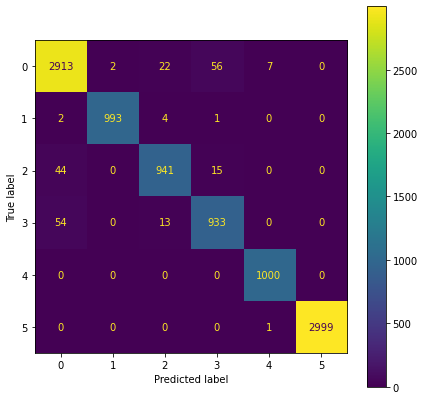


  • Classification Report for Level = 1 

              precision    recall  f1-score   support

           0    0.96681   0.97100   0.96890      3000
           1    0.99799   0.99300   0.99549      1000
           2    0.96020   0.94100   0.95051      1000
           3    0.92836   0.93300   0.93067      1000
           4    0.99206   1.00000   0.99602      1000
           5    1.00000   0.99967   0.99983      3000

    accuracy                        0.97790     10000
   macro avg    0.97424   0.97294   0.97357     10000
weighted avg    0.97790   0.97790   0.97789     10000

  • Confusion_Matrix Level = 2 


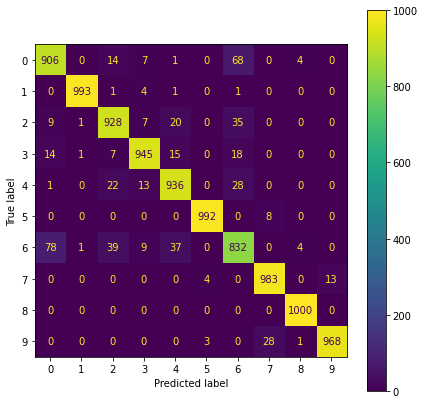


  • Classification Report for Level = 2 

              precision    recall  f1-score   support

           0    0.89881   0.90600   0.90239      1000
           1    0.99699   0.99300   0.99499      1000
           2    0.91790   0.92800   0.92292      1000
           3    0.95939   0.94500   0.95214      1000
           4    0.92673   0.93600   0.93134      1000
           5    0.99299   0.99200   0.99250      1000
           6    0.84725   0.83200   0.83956      1000
           7    0.96467   0.98300   0.97375      1000
           8    0.99108   1.00000   0.99552      1000
           9    0.98675   0.96800   0.97728      1000

    accuracy                        0.94830     10000
   macro avg    0.94826   0.94830   0.94824     10000
weighted avg    0.94826   0.94830   0.94824     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label,directory)

In [22]:
h_measurements,consistency,exact_match, get_performance_report = metrics.hmeasurements(true_label, pred_label, dataset['tree'])

get_performance_report = {**{'Dataset': dataset['name'],
                             'Model': 'HD-CapsNet'},
                             **get_performance_report
                             } # merging two dictionaries (adding Dataset and Model name)
performance_metrics = pd.DataFrame(pd.DataFrame(get_performance_report.values(), get_performance_report.keys(), columns = ['Value']))
performance_metrics.to_csv(os.path.join(directory,'performance_metrics.csv'))
display(performance_metrics)

,Value
Dataset,FMNIST
Model,HD-CapsNet
Accuracy L_0,0.9992
Accuracy L_1,0.9779
Accuracy L_2,0.9483
HarmonicM_Accuracy_k1,0.974685
HarmonicM_Accuracy_k2,0.989071
HarmonicM_Accuracy_k5,0.99433
ArithmeticM_Accuracy_k1,0.975133
ArithmeticM_Accuracy_k2,0.989167
